**Bike Network Data Analysis**

This notebook is used to perform basic analysis of both the bike network and wider underlying street network. It requires the prior notebook (00-bike-network-data-collection.ipynb) to have been run to collect the street networks from OpennStreetMap.

In [74]:
# libary imports
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import os
import networkx as nx
import momepy
import pandas as pd
import numpy as np


# get working directory
working_directory =  os.getcwd()

In [75]:
# get street networks

bike_network = ox.io.load_graphml(working_directory + "\data\\bike_network.xml")

road_network =  ox.io.load_graphml(working_directory + "\data\\road_network.xml")

# get area boundary 

boundary = gpd.read_file(working_directory + "\data\\boundary.gpkg")

In [76]:
# convert graphs to gdfs

bike_network_edges = ox.utils_graph.graph_to_gdfs(bike_network, nodes=False)

road_network_edges = ox.utils_graph.graph_to_gdfs(road_network, nodes=False)

In [77]:
# create undirected graphs with bearings

bike_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(bike_network))

road_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(road_network))

In [78]:
# calculate lenghts of streets

bike_length = (bike_network_edges['length'].sum())* 0.0001 # convert to km

road_length = (road_network_edges['length'].sum())* 0.0001 # convert to km


# save to Dataframe

lengths_df = gpd.GeoDataFrame([road_length, bike_length])

row_names = {0:'Road',
            1:'Bike Paths'}

lengths_df = lengths_df.rename(index = row_names)


(array([0, 1]), [Text(0, 0, 'Road'), Text(1, 0, 'Bike Paths')])

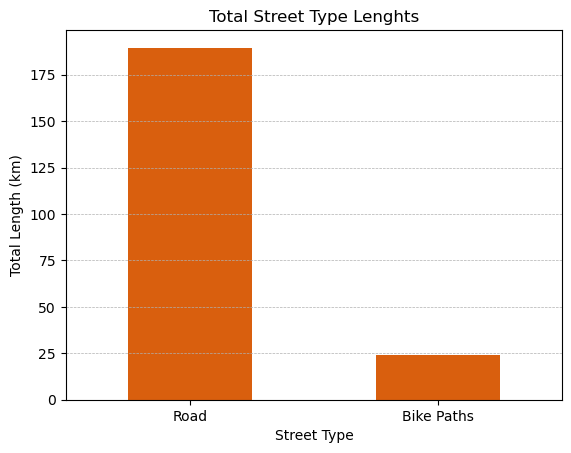

In [79]:
# plot street lenghts

colours = ['#d95f0e', '#fec44f']
ax = lengths_df.plot.bar(color=colours)
ax.set_xlabel("Street Type")
ax.set_ylabel("Total Length (km)")
ax.get_legend().remove()
plt.title("Total Street Type Lenghts")
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)

In [80]:
# calculate the ratio of road compared to bike streets

def ratioFunction(input1, input2):
    num1 = input1
    num1 = float(num1) 
    num2 = input2
    num2 = float(num2) 
    ratio12 = float(num1/num2)
    print('The ratio of road network (', num1, 'km) to bike network (', num2,'km) is 1 :', str(ratio12) + '.')
    return(ratio12)

road_to_bike_ratio = ratioFunction(road_length, bike_length)

The ratio of road network ( 189.51392420000005 km) to bike network ( 24.0302862 km) is 1 : 7.886461385549376.


In [81]:
# calculate number of disconnected components

bike_components = nx.number_connected_components(bike_network_undirected)

In [82]:
# THIS MAY NEED CHANGING
# calculate the mean level of disconnect

mean_level_of_disconnect = bike_components/bike_length 

print(mean_level_of_disconnect)

6.283737061774986


In [83]:
# find the total number of intersections 

bike_intersections = bike_network.number_of_nodes()

road_intersections = road_network.number_of_nodes()

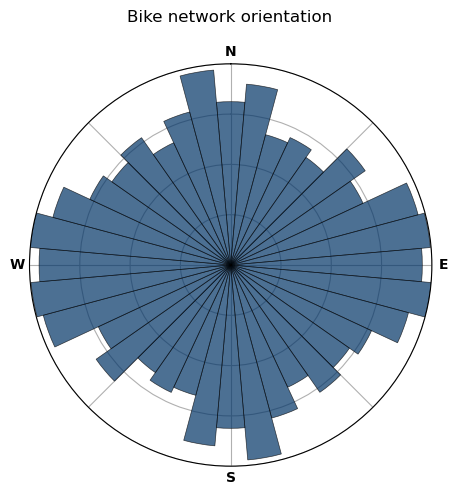

In [84]:
# measure bike network orientation

fig, ax = ox.bearing.plot_orientation(bike_network_undirected)

fig.suptitle("Bike network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)

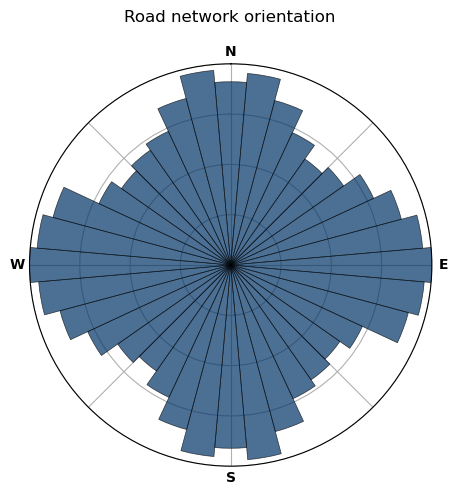

In [85]:
# measure road network orientation

fig, ax = ox.bearing.plot_orientation(road_network_undirected)

fig.suptitle("Road network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)

u            v            key
6565642      13800629     0      217.0
             13800665     0       35.1
             13801142     0       40.8
6565645      13800665     0      213.4
             13800975     0       35.4
                                 ...  
10290157928  10290157929  0       76.0
10290157929  10290157941  0      353.8
10303439286  10303439288  0      228.9
10542869618  10542869623  0      300.1
10562327168  10562327169  0      252.2
Name: bearing, Length: 11946, dtype: float64

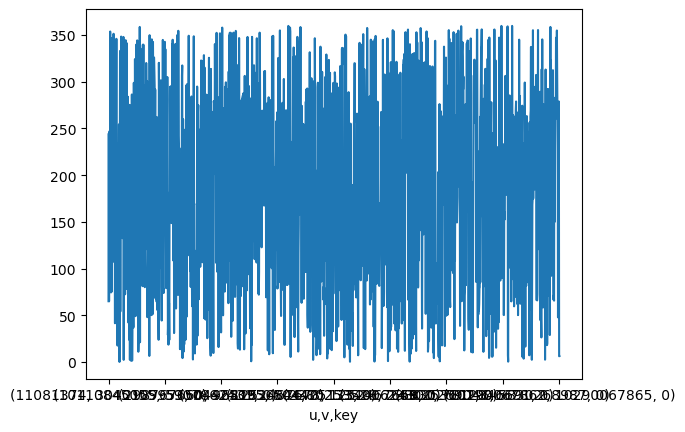

In [86]:
# want to compare these two plots somehow, find a level of differance between

# can turn u-graph to gdf to access bearing of every edge

bike_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(bike_network_undirected, nodes=False)

road_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(road_network_undirected, nodes=False)


bike_network_undirected_gdf['bearing'].plot()
road_network_undirected_gdf['bearing']

In [87]:
# calculate network stats

# boundary area is required for the ox.basic_stats function

# calculate boundary area

area = boundary.unary_union.area

# with area found, the ox.basic_stats function can be used to calculate a host of useful stats

bike_stats = ox.basic_stats(bike_network, area=area)

road_stats = ox.basic_stats(road_network, area=area)

# unpack the dictionaries of node countes and node proportions into series

for k, count in bike_stats["streets_per_node_counts"].items():
    bike_stats["{}way_int_count".format(k)] = count
for k, count in bike_stats["streets_per_node_proportions"].items():
    bike_stats["{}way_int_prop".format(k)] = count

for k, count in road_stats["streets_per_node_counts"].items():
    road_stats["{}way_int_count".format(k)] = count
for k, count in road_stats["streets_per_node_proportions"].items():
    road_stats["{}way_int_prop".format(k)] = count

# convert to dataframe and rename index column

bike_stats = pd.DataFrame(pd.Series(bike_stats, name="bike_values"))
bike_stats.index.names = ['metric']

road_stats = pd.DataFrame(pd.Series(road_stats, name="road_values"))
road_stats.index.names = ['metric']

# join dataframes

stats = bike_stats.join(road_stats, on='metric')

c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length


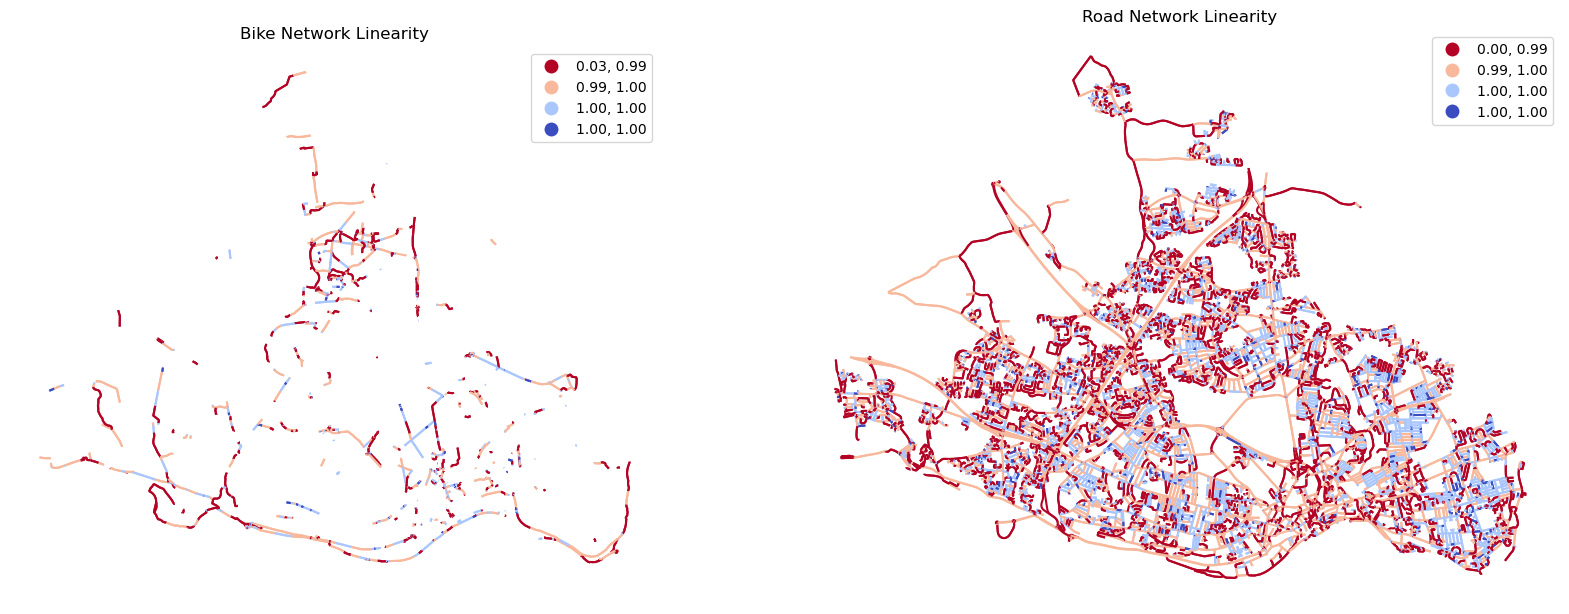

In [88]:
# calculate linearity

bike_network_lin = momepy.Linearity(bike_network_edges)
bike_network_edges['linearity'] = bike_network_lin.series

road_network_lin = momepy.Linearity(road_network_edges)
road_network_edges['linearity'] = road_network_lin.series

# plot linearity

f, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.171]})
f.set_figheight(20)
f.set_figwidth(20)
road_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[1])
bike_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[0])

ax[0].set_title('Bike Network Linearity')
ax[1].set_title('Road Network Linearity')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


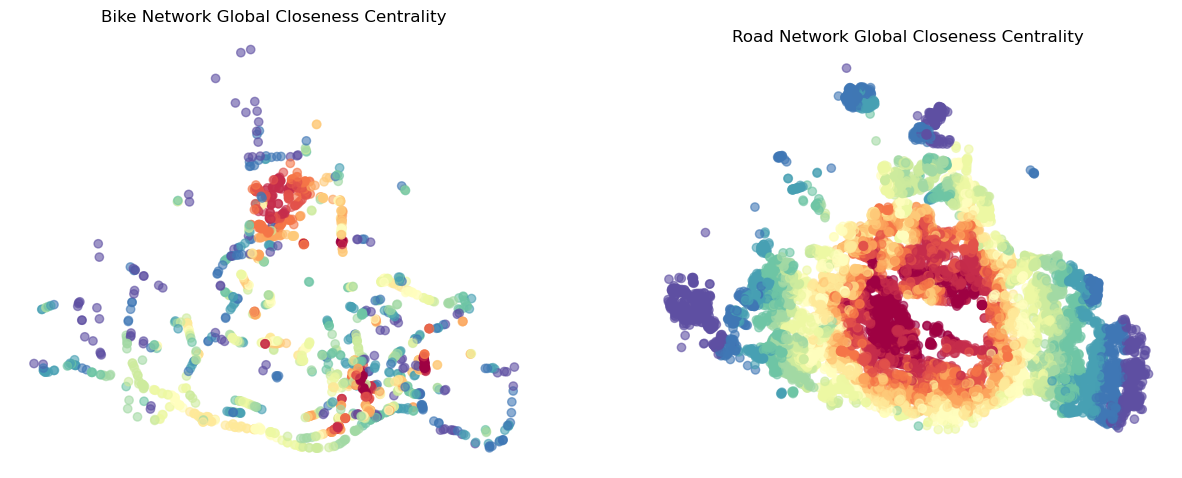

In [89]:
# calculate global closeness

# get undirected edges with edge geometry

bike_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(bike_network), nodes=False, fill_edge_geometry=True)

road_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(road_network), nodes=False, fill_edge_geometry=True)


# convert to a primal graph

primal_bike = momepy.gdf_to_nx(bike_network_edges_geom, approach='primal')

primal_road = momepy.gdf_to_nx(road_network_edges_geom, approach='primal')


# calculate global closeness centrality

primal_bike = momepy.closeness_centrality(primal_bike, name='closeness', weight='mm_len')

primal_road = momepy.closeness_centrality(primal_road, name='closeness', weight='mm_len')


# plots  

primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Global Closeness Centrality')

primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
primal_road_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Global Closeness Centrality')
plt.show()

c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


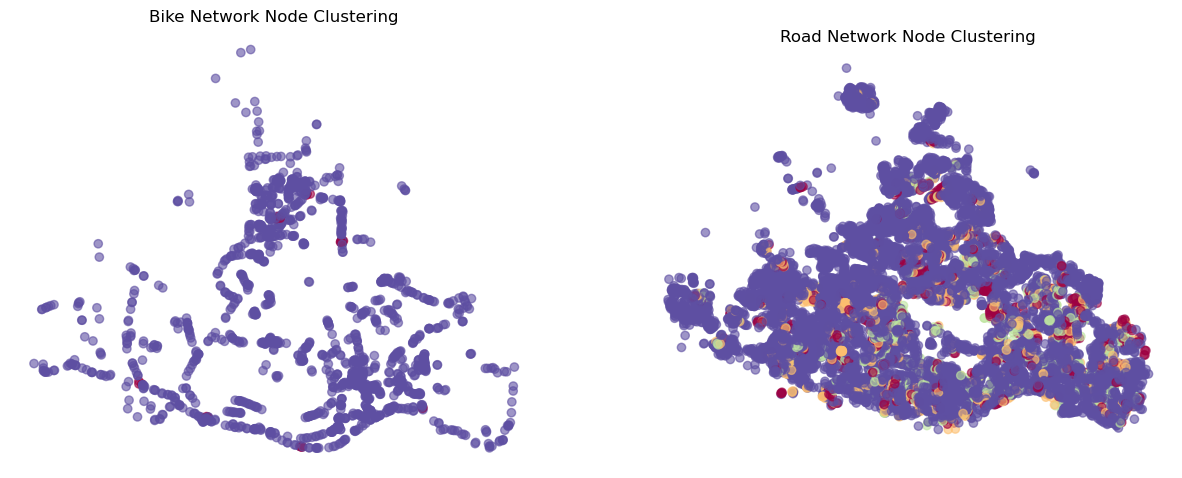

In [90]:
# calculate node clustering

primal_bike = momepy.clustering(primal_bike, name='cluster')

primal_road = momepy.clustering(primal_road, name='cluster')


# plots  

primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_nodes.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Node Clustering')

primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
primal_road_nodes.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Node Clustering')
plt.show()


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 12
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Text(0.5, 1.0, 'Road Network Node Betweenness Centrality')

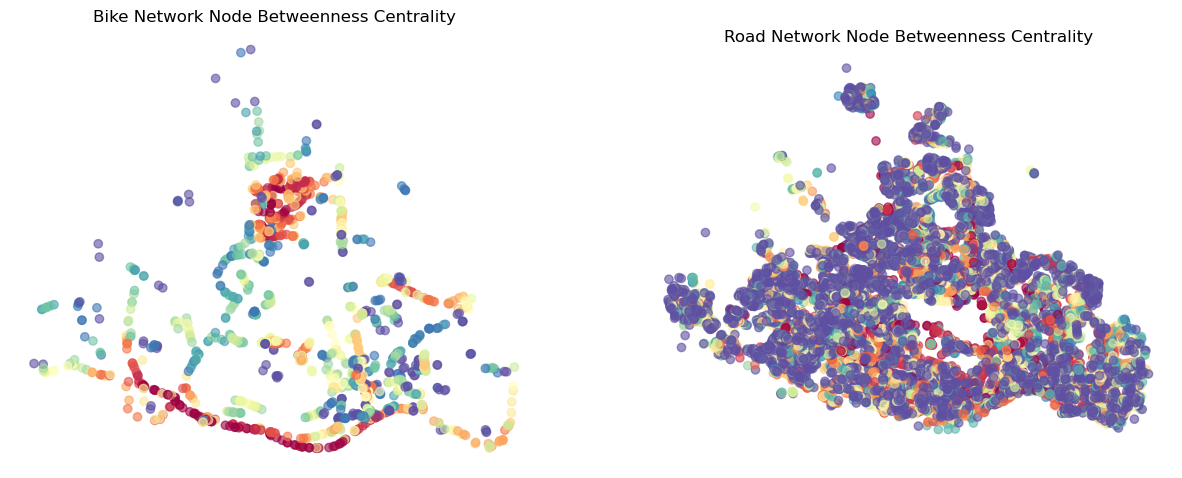

In [91]:
# calculate node based betweenness centrality

primal_bike = momepy.betweenness_centrality(primal_bike, name='betweenness_metric_n', mode='nodes', weight='mm_len')

primal_road = momepy.betweenness_centrality(primal_road, name='betweenness_metric_n', mode='nodes', weight='mm_len')

# plots 

primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_nodes.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Node Betweenness Centrality')


primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
primal_road_nodes.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Node Betweenness Centrality')


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 13
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Text(0.5, 1.0, 'Road Network Edge Betweenness Centrality')

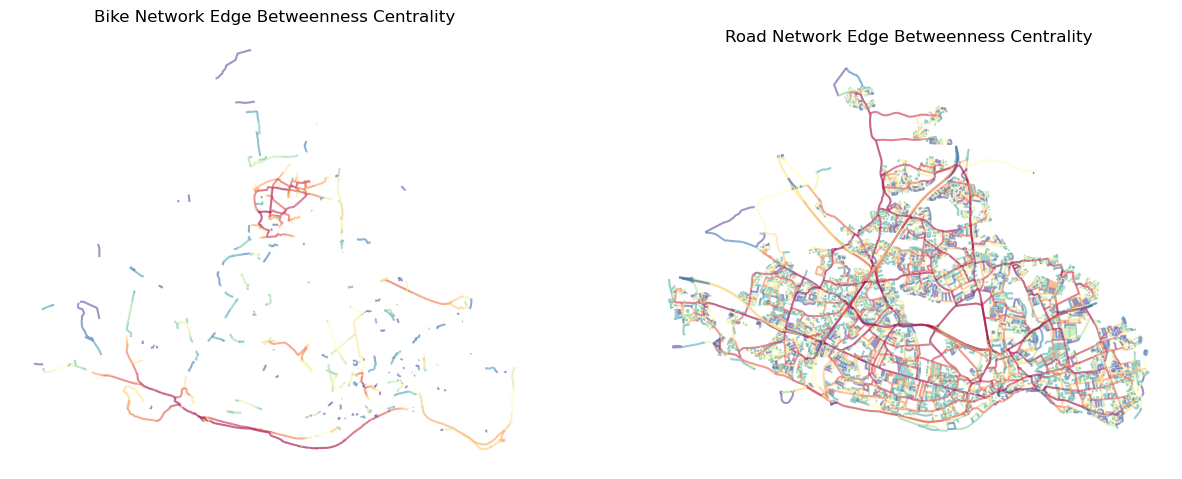

In [92]:
# calculate edge based betweenness centrality

primal_bike = momepy.betweenness_centrality(primal_bike, name='betweenness_metric_e', mode='edges', weight='mm_len')

primal_road = momepy.betweenness_centrality(primal_road, name='betweenness_metric_e', mode='edges', weight='mm_len')

# plots 

primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_edges.plot(column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Edge Betweenness Centrality')


primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
primal_road_edges.plot(column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Edge Betweenness Centrality')

Text(0.5, 1.0, 'Road Network Straightness Centrality')

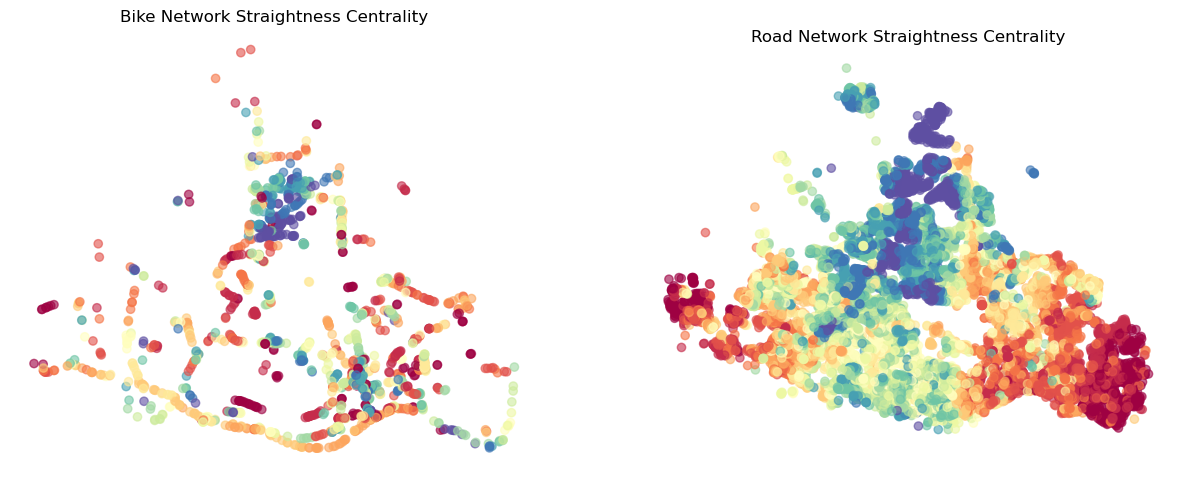

In [93]:
# calcualte straightness centrality

primal_bike = momepy.straightness_centrality(primal_bike, name='straightness')

primal_road = momepy.straightness_centrality(primal_road, name='straightness')

# plots 

primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_nodes.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Straightness Centrality')


primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
primal_road_nodes.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Straightness Centrality')


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 14
  Warn("Warning: setting k to %d" % k_q, UserWarning)
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\mapclassify\classifiers.py:241: U

Text(0.5, 1.0, 'Road Network Clustering')

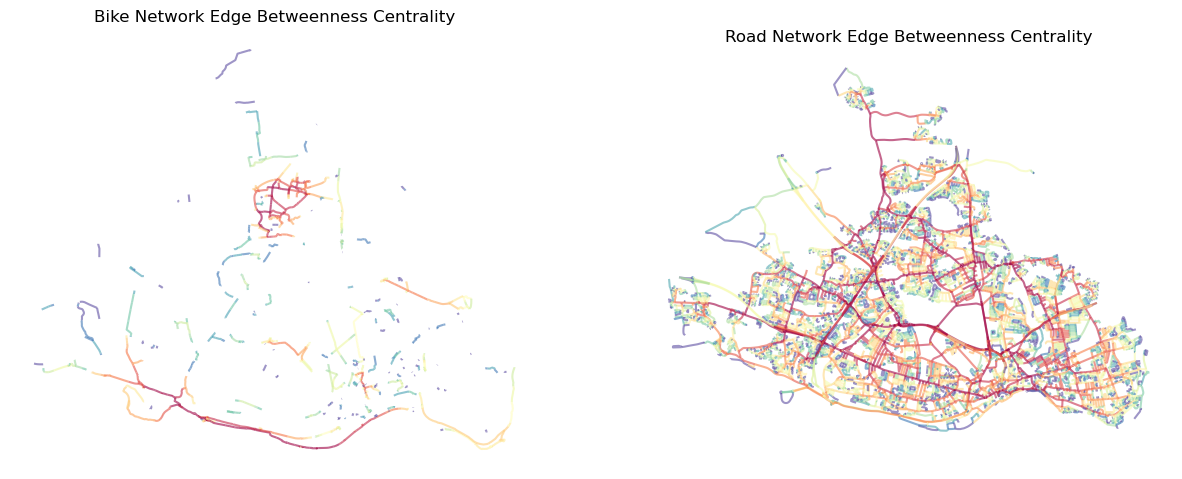

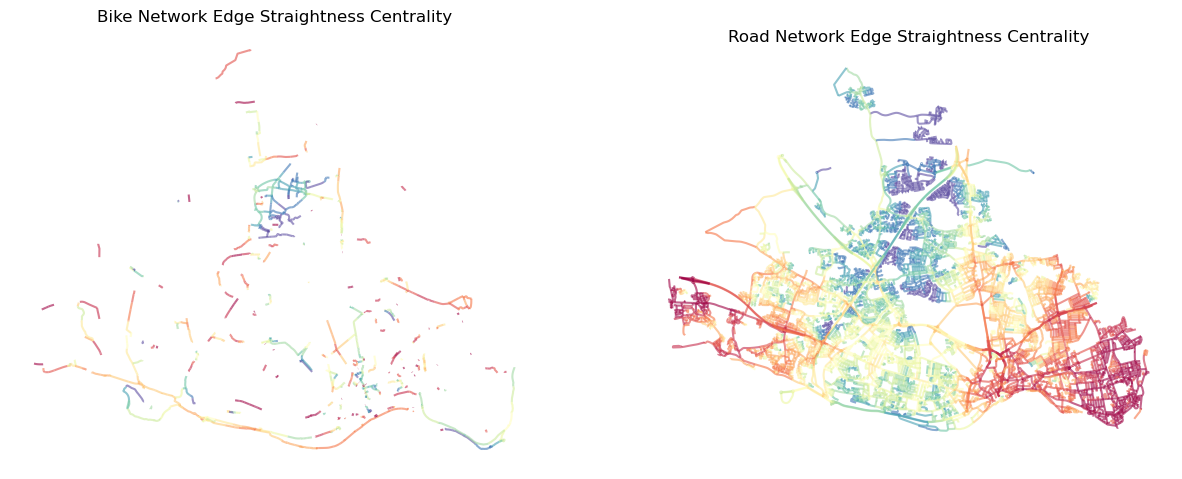

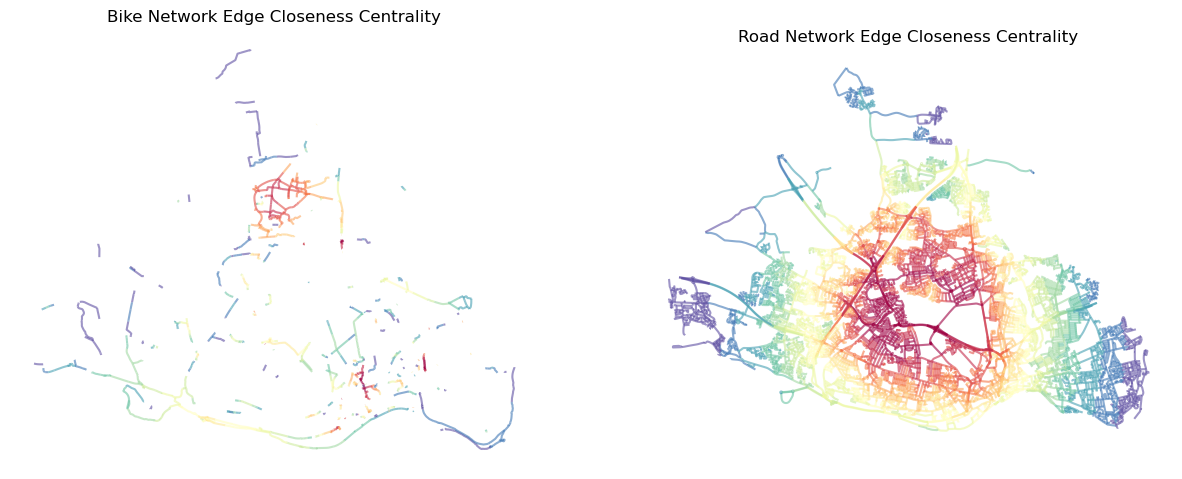

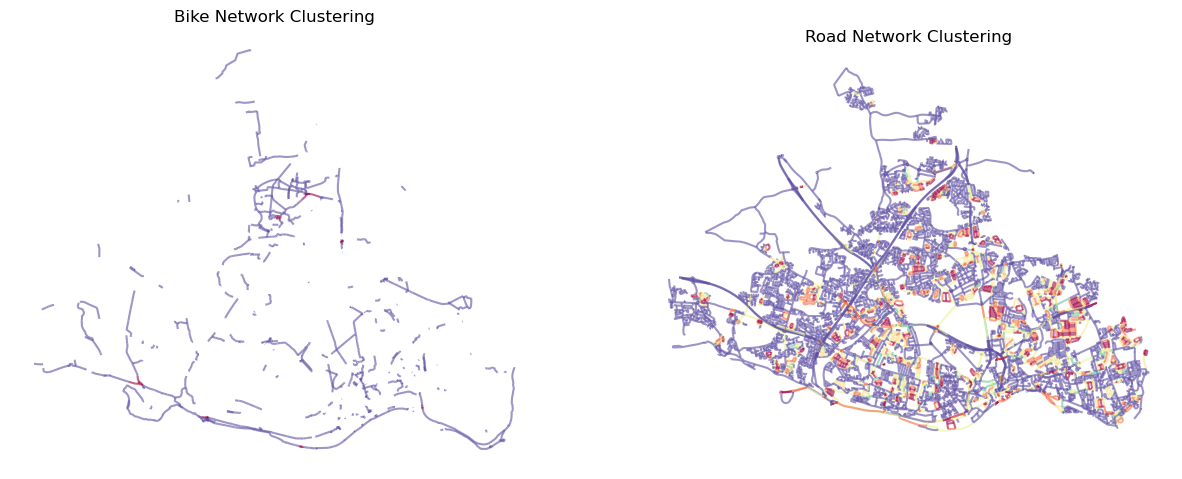

In [97]:
# average node values onto edges

momepy.mean_nodes(primal_bike, 'straightness')
momepy.mean_nodes(primal_bike, 'closeness')
momepy.mean_nodes(primal_bike, 'betweenness_metric_n')
momepy.mean_nodes(primal_bike, 'cluster')

momepy.mean_nodes(primal_road, 'straightness')
momepy.mean_nodes(primal_road, 'closeness')
momepy.mean_nodes(primal_road, 'betweenness_metric_n')
momepy.mean_nodes(primal_road, 'cluster')


# plot betweenness

primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_edges.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Edge Betweenness Centrality')


primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
primal_road_edges.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Edge Betweenness Centrality')


# plot straightness

primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_edges.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Edge Straightness Centrality')


primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
primal_road_edges.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Edge Straightness Centrality')


# plot closeness

primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_edges.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Edge Closeness Centrality')


primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
primal_road_edges.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Edge Closeness Centrality')



# plot clustering


primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_edges.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Clustering')


primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
primal_road_edges.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Clustering')





In [ ]:
# TO DO LIST

# Angualar closeness on dual graphs (local and global)
# Angular betwenness

In [94]:
stats

,bike_values,road_values
metric,,
n,1690,9827
m,3118,22426
k_avg,3.689941,4.56416
edge_length_total,240302.862,1895139.242
edge_length_avg,77.069552,84.506343
streets_per_node_avg,3.301775,2.435331
streets_per_node_counts,"{0: 0, 1: 35, 2: 7, 3: 1082, 4: 547, 5: 18, 6:...","{0: 0, 1: 3049, 2: 42, 3: 6158, 4: 566, 5: 11,..."
streets_per_node_proportions,"{0: 0.0, 1: 0.020710059171597635, 2: 0.0041420...","{0: 0.0, 1: 0.3102676299989824, 2: 0.004273939..."
intersection_count,1655,6778


In [95]:
 # to do list

#  want to compare bearing plots somehow, find a level of differance between
#  want to find how strong the correlation is between spatail distrubtion of bike vs road
#  look at widths of roads/bike paths
